# thal1 Fourier Coefficients

Get Fourier coefficients for $\mathcal{H}$-functions. To be used to generate two-parameter bifurcation diagrams in XPP.

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal1 as t1
from lib.functions import g3

#from lib.util import (get_phase, _get_sol,load_bif1d_f,load_phis_force, get_init_point_force, )

from generate_figures import _full_thal1

from lib.rhs import _redu_c, _full, rhs_avg_1df
from lib.plot_util import add_diagram_1d

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
def g4(x):
    return (g3(x)/2.7)**3

In [3]:
kw_sim = {'rtol':1e-6,'atol':1e-6,'method':'LSODA'}

In [4]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [5]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r'],
        'pardict':pd1,
        'rhs':t1.rhs,
        'init':np.array([-.64,0.71,0,10.6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':False,
        'i_bad_dx':[False,True,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'forcing_fn':[lambda x: -g4(x),lambda x:20*(g4(x+2))],
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1,
        'save_fig':True}

## Defs

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
eps_list11r = np.linspace(0.001,.1,50)
etup11 = (.001,.1,50)

In [8]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [9]:
def get_coeffs(a,k,threshold=0.1):
    coeffs = np.fft.fft(a.system1.h['dat'][k])
    
    # get coeffs above threshold
    coeffs_re_all = np.real(coeffs)
    coeffs_im_all = np.imag(coeffs)
    nn = np.arange(len(coeffs),dtype='int')
    
    coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<a.NH/2)
    coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<a.NH/2)
    
    print(coeffs_re_bool.sum(),np.where(coeffs_re_bool>0))
    print(coeffs_im_bool.sum(),np.where(coeffs_im_bool>0))
    
    print('re',coeffs_re_all[coeffs_re_bool])
    print('im',coeffs_im_all[coeffs_im_bool])
    
    freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
    coeffs_re = coeffs_re_all[coeffs_re_bool]
    coeffs_im = coeffs_im_all[coeffs_im_bool]
    
    freqs[coeffs_re_bool]

    return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    tot = 0
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            tot += c/a.NH
        else:
            tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
    for i,c in enumerate(coeffs_im):
        tot += -2*c*np.sin(a.x*fi[i])/a.NH

    return tot

def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a.NH)
        else:
            eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
    for i,c in enumerate(coeffs_im):
        eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a.NH
    return eq


## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thalf0',**kws1)

mkdir ./data/thalf0/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981420040301
LC0 ini[-0.10742889  0.22848616  0.09385013]
LC0 fin[-0.10742888  0.22848617  0.09385012]
* Loading monodromy...
* Floquet Exponent kappa =-0.024354476053816677
* Loading g symbolic...
* Computing g...
g0 ini[0. 0. 0.]
g0 fin[0. 0. 0.]
g1 ini[-0.00392138  0.93590097  0.35224138]
g1 fin[-0.00392138  0.93590097  0.35224138]
* Loading heterogeneous terms...
* Computing z...
z0 ini[-0.86890695 -1.20965439  3.20436342]
z0 fin[-0.86890694 -1.20965437  3.20436336]
z1 ini[ 2.63290751  1.04789014 -0.20900063]
z1 fin[ 2.63290751  1.04789014 -0.20900063]
* Computing i...
i0 ini[ 0.14832161 -0.01130593  2.8706532 ]
i0 fin[ 0.14832161 -0.01130593  2.8706532 ]
i1 ini[-0.08308497  0.69291962 -0.06360567]
i1 fin[-0.08308503  0.69291955 -0.06360566]


# 1:1

In [11]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm11 = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',1),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [12]:
del11_p01 = 0.01
a11 = nm.nmCoupling(**kw_nm11)

Initializing 11 Coupling...
* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...


Might need to stick with Fourier coefficients. At least for CGL. Much simpler this way.

Recall: Given the fourier coefficients $c_n$ for $n \in\mathbb{Z}$ and supposing that $c_n = a_n + i b_n$, the real Fourier series is given by,
$$\sum_{n =1}^\infty 2 a_n \cos(n \omega t) - 2 b_n \sin(n \omega t).$$
So I really only need to save the coefficients for positive frequencies and double them. 

Goal: given a function, display a list of coefficients (maybe implement text output to copy/past into XPP)

## eps coeffs

In [13]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,0,threshold=5)

4 (array([0, 1, 2, 3]),)
3 (array([1, 2, 3]),)
re [-1517.3644754    540.91533357    66.85058854    11.74286562]
im [-599.85198496  -41.96106621   11.6901563 ]


In [14]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

-1.4818+2*cos(x*1.0)*(0.5282)+2*cos(x*2.0)*(0.0653)+2*cos(x*3.0)*(0.0115)-2*sin(x*1.0)*(-0.5858)-2*sin(x*2.0)*(-0.0410)-2*sin(x*3.0)*(0.0114)


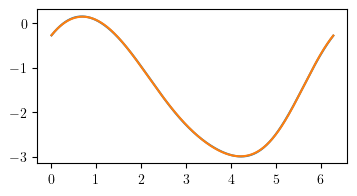

In [15]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][0])

## eps^2 coeffs

In [16]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,1,threshold=5)

5 (array([0, 1, 2, 3, 4]),)
5 (array([1, 2, 3, 4, 5]),)
re [ 3.24101038e+04  1.47886736e+04 -1.29955273e+02  5.00291807e+00 -3.41422828e+01]
im [3787.67979547 -707.0508011   -64.33809994   21.63000633    5.06057428]


In [17]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

31.6505+2*cos(x*1.0)*(14.4421)+2*cos(x*2.0)*(-0.1269)+2*cos(x*3.0)*(0.0049)+2*cos(x*4.0)*(-0.0333)-2*sin(x*1.0)*(3.6989)-2*sin(x*2.0)*(-0.6905)-2*sin(x*3.0)*(-0.0628)-2*sin(x*4.0)*(0.0211)-2*sin(x*5.0)*(0.0049)


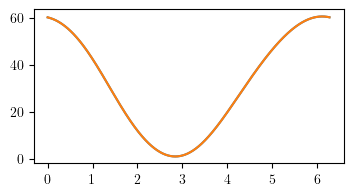

In [18]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][1])

## Save data

In [19]:
# xlo = a11.x[0]
# xhi = a11.x[-1]
# npts = len(a11.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a11.system1.miter):
#     d = a11.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a11._n[1],a11._m[1],k),d,
#               fmt='%.18f')

# 2:1

In [20]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm21 = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',1),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [21]:
del21_p01 = 0.01
a21 = nm.nmCoupling(**kw_nm21)

Initializing 21 Coupling...
* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...


## eps coeffs

In [22]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,0,threshold=2)

3 (array([0, 2, 4]),)
2 (array([2, 4]),)
re [-1517.3644754    307.19861021     9.69778303]
im [-340.67012834   -6.08714635]


In [23]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

-1.4818+2*cos(x*2.0)*(0.3000)+2*cos(x*4.0)*(0.0095)-2*sin(x*2.0)*(-0.3327)-2*sin(x*4.0)*(-0.0059)


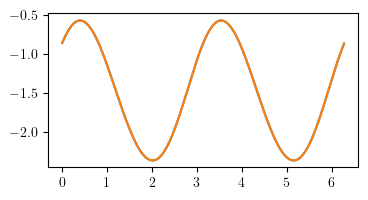

In [24]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][0])

## eps^2 coeffs

In [25]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,1,threshold=2)

4 (array([0, 2, 4, 6]),)
3 (array([2, 4, 6]),)
re [ 3.10856384e+04 -1.62811024e+03  5.75783877e+01  9.13992310e+00]
im [-9606.66324765   473.45569901    12.74260706]


In [26]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

30.3571+2*cos(x*2.0)*(-1.5900)+2*cos(x*4.0)*(0.0562)+2*cos(x*6.0)*(0.0089)-2*sin(x*2.0)*(-9.3815)-2*sin(x*4.0)*(0.4624)-2*sin(x*6.0)*(0.0124)


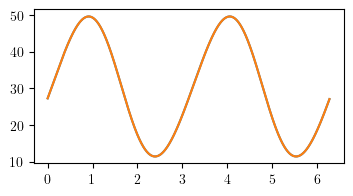

In [27]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][1])

## Save data

In [28]:
# xlo = a21.x[0]
# xhi = a21.x[-1]
# npts = len(a21.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a21.system1.miter):
#     d = a21.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a21._n[1],a21._m[1],k),d,
#               fmt='%.18f')

# 1:2

In [29]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm12 = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',2),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [30]:
del12_p001 = 0.001
a12 = nm.nmCoupling(**kw_nm12)

Initializing 12 Coupling...
* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...


## eps coeffs

In [31]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a12,0,threshold=2)

3 (array([0, 2, 4]),)
3 (array([2, 4, 6]),)
re [-1517.3644754    117.71052081    10.94936245]
im [-73.88504821  21.43799754   2.0221007 ]


In [32]:
tot = call_fourier_series(a12,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a12,coeffs_re,coeffs_im,fr,fi))

-1.4818+2*cos(x*2.0)*(0.1150)+2*cos(x*4.0)*(0.0107)-2*sin(x*2.0)*(-0.0722)-2*sin(x*4.0)*(0.0209)-2*sin(x*6.0)*(0.0020)


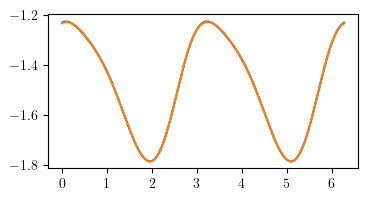

In [33]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a12.x,tot)
axs.plot(a12.x,a12.system1.h['dat'][0])

## eps^2 coeffs

In [34]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a12,1,threshold=2)

6 (array([ 0,  2,  4,  6,  8, 10]),)
3 (array([2, 4, 6]),)
re [ 3.05145865e+04  2.00001804e+03  6.98424792e+02  2.63111473e+01 -5.19546604e+00 -2.02090981e+00]
im [1197.14110954  118.4881795     6.15709533]


In [35]:
tot = call_fourier_series(a12,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a12,coeffs_re,coeffs_im,fr,fi))

29.7994+2*cos(x*2.0)*(1.9531)+2*cos(x*4.0)*(0.6821)+2*cos(x*6.0)*(0.0257)+2*cos(x*8.0)*(-0.0051)+2*cos(x*10.0)*(-0.0020)-2*sin(x*2.0)*(1.1691)-2*sin(x*4.0)*(0.1157)-2*sin(x*6.0)*(0.0060)


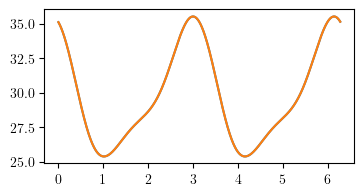

In [36]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a12.x,tot)
axs.plot(a12.x,a12.system1.h['dat'][1])

## Save data

In [37]:
# xlo = a12.x[0]
# xhi = a12.x[-1]
# npts = len(a12.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a12.system1.miter):
#     d = a12.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a12._n[1],a12._m[1],k),d,
#               fmt='%.18f')

# 2:3

In [38]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm23 = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',3),
         'NH':1024,'save_fig':False,'recompute_list':recompute_list}

In [39]:
del23_p002 = 0.0001
a23 = nm.nmCoupling(**kw_nm23)

Initializing 23 Coupling...
* Loading p...
* Loading H thalf0, order=0...
* Loading H thalf0, order=1...


## eps coeffs

In [40]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a23,0,threshold=2)

2 (array([0, 6]),)
1 (array([6]),)
re [-1517.3644754     27.47082914]
im [27.3475229]


In [41]:
tot = call_fourier_series(a23,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a23,coeffs_re,coeffs_im,fr,fi))

-1.4818+2*cos(x*6.0)*(0.0268)-2*sin(x*6.0)*(0.0267)


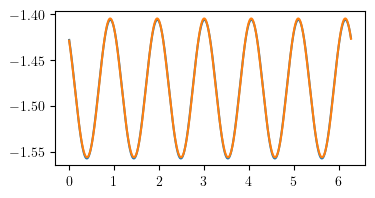

In [42]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a23.x,tot)
axs.plot(a23.x,a23.system1.h['dat'][0])

## eps^2 coeffs

In [43]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a23,1,threshold=2)

2 (array([0, 6]),)
2 (array([ 6, 12]),)
re [30390.54242508   878.51884883]
im [-199.68956965    6.41990518]


In [44]:
tot = call_fourier_series(a23,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a23,coeffs_re,coeffs_im,fr,fi))

29.6783+2*cos(x*6.0)*(0.8579)-2*sin(x*6.0)*(-0.1950)-2*sin(x*12.0)*(0.0063)


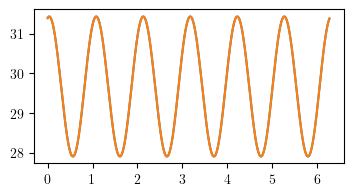

In [45]:
fig,axs = plt.subplots(figsize=(4,2))
axs.plot(a23.x,tot)
axs.plot(a23.x,a23.system1.h['dat'][1])

## Save data

In [46]:
# xlo = a23.x[0]
# xhi = a23.x[-1]
# npts = len(a23.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a23.system1.miter):
#     d = a23.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a23._n[1],a23._m[1],k),d,
#               fmt='%.18f')